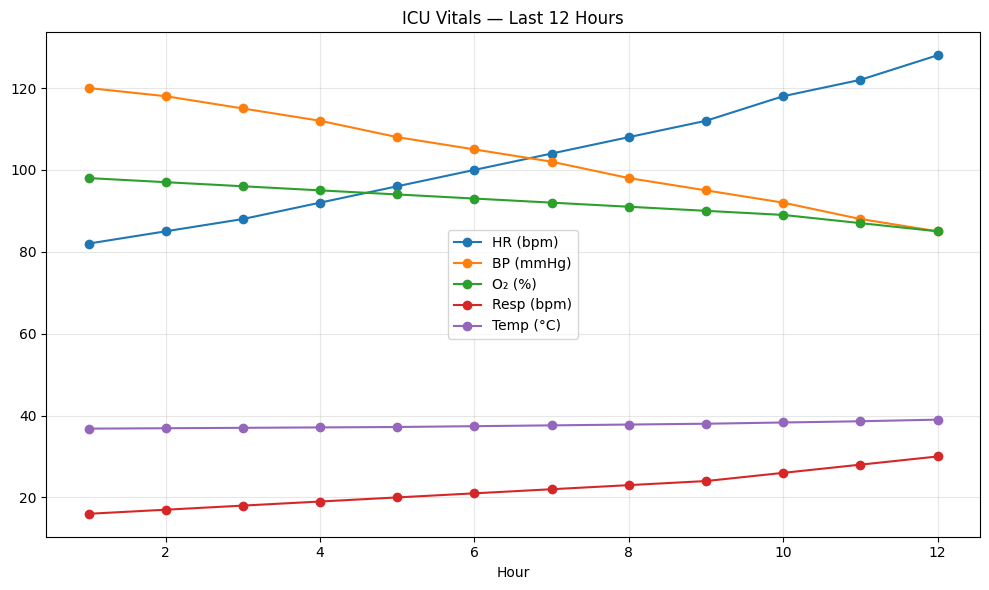

Predicted risk (next 6 hours) — SGD : [0.542 0.434 0.486 0.471 0.515 0.463]
Predicted risk (next 6 hours) — Adam: [0.483 0.469 0.545 0.48  0.51  0.49 ]


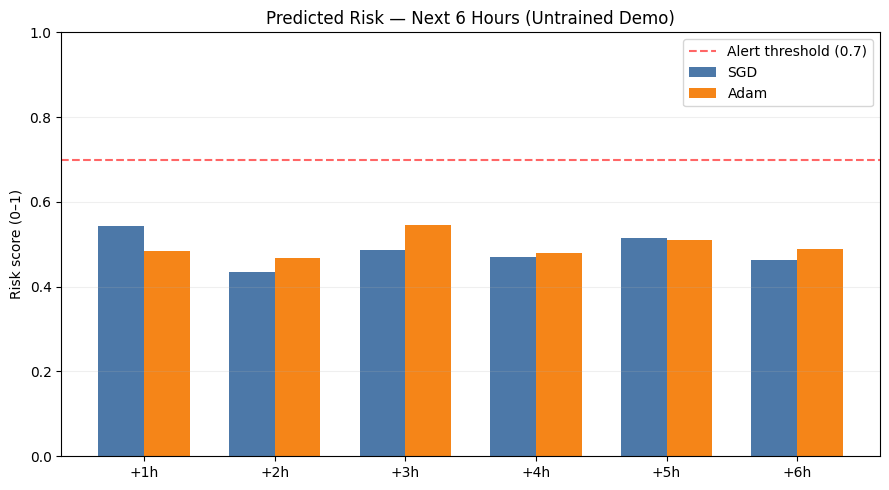


Alerts (SGD):
  +1h: 0.542 -> OK
  +2h: 0.434 -> OK
  +3h: 0.486 -> OK
  +4h: 0.471 -> OK
  +5h: 0.515 -> OK
  +6h: 0.463 -> OK

Alerts (Adam):
  +1h: 0.483 -> OK
  +2h: 0.469 -> OK
  +3h: 0.545 -> OK
  +4h: 0.480 -> OK
  +5h: 0.510 -> OK
  +6h: 0.490 -> OK


In [ ]:



import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


tf.random.set_seed(1)
np.random.seed(1)

vitals_12h = np.array([
    [ 82, 120, 98, 16, 36.8],
    [ 85, 118, 97, 17, 36.9],
    [ 88, 115, 96, 18, 37.0],
    [ 92, 112, 95, 19, 37.1],
    [ 96, 108, 94, 20, 37.2],
    [100, 105, 93, 21, 37.4],
    [104, 102, 92, 22, 37.6],
    [108,  98, 91, 23, 37.8],
    [112,  95, 90, 24, 38.0],
    [118,  92, 89, 26, 38.3],
    [122,  88, 87, 28, 38.6],
    [128,  85, 85, 30, 39.0],
], dtype=np.float32)

FEATURE_NAMES = ["HR (bpm)", "BP (mmHg)", "O₂ (%)", "Resp (bpm)", "Temp (°C)"]
INPUT_LEN   = 12   # past hours
N_FEATURES  = 5    # HR, BP, O2, Resp, Temp
OUT_HORIZON = 6    # risk for next 6 hours


hours = np.arange(1, INPUT_LEN + 1)
plt.figure(figsize=(10, 6))
for i, name in enumerate(FEATURE_NAMES):
    plt.plot(hours, vitals_12h[:, i], marker='o', label=name)
plt.title("ICU Vitals — Last 12 Hours")
plt.xlabel("Hour")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


x_mean = vitals_12h.mean(axis=0, keepdims=True)
x_std  = vitals_12h.std(axis=0, keepdims=True) + 1e-8
X_in   = (vitals_12h - x_mean) / x_std
X_in   = X_in[np.newaxis, ...]  # shape: (1, 12, 5)

-
def build_model():
    model = Sequential([
        LSTM(32, input_shape=(INPUT_LEN, N_FEATURES)),
        Dense(16, activation='relu'),
        Dense(OUT_HORIZON, activation='sigmoid')  # risk in [0,1] for next 6 hours
    ])
    return model


opt_sgd  = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, clipnorm=1.0)
opt_adam = tf.keras.optimizers.Adam(learning_rate=1e-3, clipnorm=1.0)


model_sgd  = build_model()
model_adam = build_model()
model_sgd.compile(optimizer=opt_sgd,  loss='mse')
model_adam.compile(optimizer=opt_adam, loss='mse')


risk_sgd  = model_sgd.predict(X_in, verbose=0)[0]   # shape: (6,)
risk_adam = model_adam.predict(X_in, verbose=0)[0]  # shape: (6,)

print("Predicted risk (next 6 hours) — SGD :", np.round(risk_sgd,  3))
print("Predicted risk (next 6 hours) — Adam:", np.round(risk_adam, 3))

horizons = np.arange(1, OUT_HORIZON + 1)
width = 0.35

plt.figure(figsize=(9, 5))
plt.bar(horizons - width/2, risk_sgd,  width=width, label="SGD",  color="#4C78A8")
plt.bar(horizons + width/2, risk_adam, width=width, label="Adam", color="#F58518")
plt.axhline(0.7, color='r', linestyle='--', alpha=0.6, label="Alert threshold (0.7)")
plt.xticks(horizons, [f"+{h}h" for h in horizons])
plt.ylim(0, 1)
plt.title("Predicted Risk — Next 6 Hours (Untrained Demo)")
plt.ylabel("Risk score (0–1)")
plt.grid(True, axis='y', alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()


THRESHOLD = 0.7
print("\nAlerts (SGD):")
for h, r in enumerate(risk_sgd, start=1):
    print(f"  +{h}h: {r:.3f} -> {'ALERT' if r >= THRESHOLD else 'OK'}")

print("\nAlerts (Adam):")
for h, r in enumerate(risk_adam, start=1):
    print(f"  +{h}h: {r:.3f} -> {'ALERT' if r >= THRESHOLD else 'OK'}")


from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)


model_sgd = build_model()
model_sgd.compile(optimizer=opt_sgd, loss='mse', metrics=['mae'])
hist_sgd = model_sgd.fit(X_train, y_train, validation_data=(X_val, y_val),
                         epochs=200, batch_size=32, callbacks=[es], verbose=1)

model_adam = build_model()
model_adam.compile(optimizer=opt_adam, loss='mse', metrics=['mae'])
hist_adam = model_adam.fit(X_train, y_train, validation_data=(X_val, y_val),
                           epochs=200, batch_size=32, callbacks=[es], verbose=1)

def plot_history(h, title):
    plt.figure(figsize=(7,4))
    plt.plot(h.history['loss'], label='train MSE')
    plt.plot(h.history['val_loss'], label='val MSE')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_history(hist_sgd,  "Training — SGD")
plot_history(hist_adam, "Training — Adam")
